# Large Scale Kernel Models

> _Author:_ Giacomo Turri — [g-turri](https://github.com/g-turri)

In our exploration of the `kooplearn` library, we delve into the utilization of kernel methods for analyzing dynamical systems. Our initial exposure to the library, as discussed in the [getting started](getting_started) example, involved studying the behavior of the _noisy logistic map_ using the {class}`kooplearn.models.Nonlinear` class.

Expanding our investigation, we now turn our attention to two additional classes within the library: {class}`kooplearn.models.Kernel` and {class}`kooplearn.models.NystroemKernel`. These classes leverage kernel methods to effectively model the transfer operator $\mathcal{T}$. Our focus is on comparing the performance of three models implemented in the above classes:

1.   Reduced Rank Regression (RRR) as described in {footcite:t}`Kostic2022`,
2.   Nyström Reduced Rank Regression (Nyström-RRR) as described in {footcite:t}`Meanti2023`,
3.   Randomized Reduced Rank Regression (Randomized-RRR) as described in {footcite:t}`Turri2023`

by investigating the Lorenz-63 System (a.k.a. Lorenz attractor). This model is defined by a system of three coupled ordinary differential equations:

$$
  \begin{align}
  \dot{x} &= \sigma (y - x), \\
  \dot{y} &= x (\rho - z) - y, \\
  \dot{z} &= x y - \beta z
  \end{align}
$$

where:
- $x, y, z$ are the three variables representing the state of the system;
- $t$ is time;
- $\sigma$, $\rho$, and $\beta$ are parameters of the system.

These parameters play crucial roles in determining the behavior of the Lorenz-63 system. In this notebook, we study the "canonical" configuration, employing the parameter values Edward Lorenz originally used in his seminal paper in 1963: $\sigma=10$, $\rho=28$, and $\beta=8/3$. In this configuration, the Lorenz-63 system exhibits a chaotic attractor known as the Lorenz attractor, which is a butterfly-shaped trajectory in state space.

## Setup `kooplearn` + importing dependecies

In [1]:
import importlib

for module in ['kooplearn', 'ml_confs', 'scienceplots']:
    try:
        importlib.import_module(module)
    except ImportError:
      if module == 'kooplearn':
        module = 'kooplearn[full]'
      %pip install -q {module}

In [2]:
# Import dependencies
import functools
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ml_confs
from tqdm.notebook import tqdm
# Plotting settings
plt.style.use(['science','sans','bright'])
plt.rcParams.update({'text.usetex' : False})

In [3]:
configs = ml_confs.from_dict({
    'train_samples': 10000,
    'test_samples': 100,
})

# Wrapper function useful for measuring the execution time of functions
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
from time import perf_counter
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

## Data Generation
In `kooplearn`, we provide an implementation of the Lorenz-63 system in {class}`kooplearn.datasets.Lorenz63`. With this class, we sample the dataset by setting the initial condition `X0` equal to 1 for the three components, the number of time steps `T` according to the sample sizes defined above.

In [4]:
from kooplearn.datasets import Lorenz63

raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs.train_samples + 1000 + configs.test_samples)
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm

dataset = {
    "train": data[:configs.train_samples + 1],
    "test": data[-configs.test_samples - 1:],
}

Here, we provide a visualization of the sampled trajectory. The blue and pink lines represent the training and test trajectories, respectively.

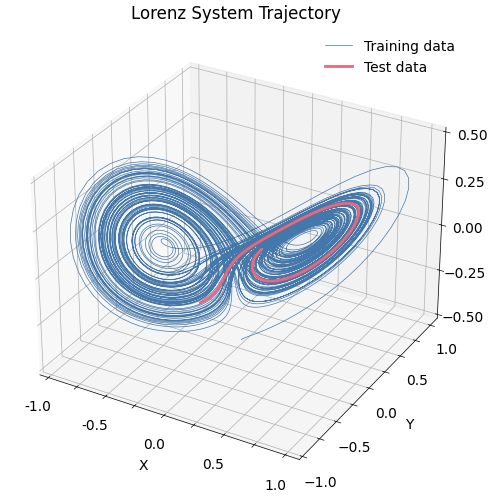

In [5]:


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(dataset['train'][:,0], dataset['train'][:,1], dataset['train'][:,2], lw=.5, label='Training data')
ax.plot(dataset['test'][:,0], dataset['test'][:,1], dataset['test'][:,2], lw=2, label='Test data')
ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X")
ax.set_xticks(np.linspace(-1,1,5),)
ax.set_xticklabels(np.linspace(-1,1,5))
ax.set_ylabel("Y")
ax.set_yticks(np.linspace(-1,1,5))
ax.set_zlabel("Z")
ax.set_zticks(np.linspace(-.5,.5,5))

spacing = 0.25
minorLocator = MultipleLocator(spacing)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which = 'minor')

plt.legend()
plt.show()

After having generated the trajectories, as already seen in the [getting started](getting_started) tutorial, we organize them into context windows using the {meth}`kooplearn.data.traj_to_contexts` method.

In [6]:
from kooplearn.data import traj_to_contexts

# From trajectories to context windows
contexts = {k: traj_to_contexts(v) for k, v in dataset.items()} # Converting the trajectories to contexts
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (10000, 2, 3): 10000 contexts of length 2 with 3 features each
Test contexts have shape (100, 2, 3): 100 contexts of length 2 with 3 features each


## Estimators fitting

Here, we show how to fit the estimators and learn the transfer operator $\mathcal{T}$ in reproducing kernel Hilbert space (RKHS). The first step in training the estimators is the choice of the kernel. In this example, we choose the standard Gaussian kernel and set its length scale using median heuristics.

Then, the hyperparameters to be tuned, common to the three estimators under consideration, are:
- The Tikhonov regularization, `tikhonov_reg`, which should be a small positive number to ensure stability and generalizability,
- The `rank` of the model, which depends on the system being analyzed.

Concerning RRR and Nyström-RRR models we can choose the `svd_solver` to be `full`, computing the exact SVD decomposition with LAPACK sover, or `arnoldi`, exploiting arnoldi iterations with ARPACK solver.

Moreover, for Nyström-RRR model we can set the number of Nyström centers, `num_centers`, where we look for a tradeoff between a fast model to train (small value) and an accurate model (large value).

Finally, in the randomized-RRR model which leverages Gaussian sketching, we can set:
- `iterated_power` *(int)*, the number of power iterations,
- `n_oversamples` *(int)*, the number of oversamples,
- `optimal_sketching` *(bool)*, whether performing optimal sketching or not.

In [7]:
from kooplearn.models import Kernel, NystroemKernel
from scipy.spatial.distance import pdist
from sklearn.gaussian_process.kernels import RBF

reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
data_pdist = pdist(dataset['train'])
kernel = RBF(length_scale=np.quantile(data_pdist, 0.5))

In [8]:
def runner(models, stop):
    results = {}
    for name, model in models.items():
        model, fit_time = timer(model.fit)(contexts['train'][:stop])
        # One-step prediction
        X_pred_test = model.predict(contexts['train'])
        X_true_test = contexts['train'].lookforward(model.lookback_len)

        results[name] = {
            'fit_time': fit_time,
            'RMSE_onestep_test': np.sqrt(np.mean((X_pred_test - X_true_test)**2)),
        }
        print(r'Fitting of {} model took {:.2f}s and has a test RMSE of {:.5f}.'.format(name, results[name]['fit_time'], results[name]['RMSE_onestep_test']))
    return results

We study the performance of the three models in terms of root-mean-square error (RMSE) of the one-step prediction on the test set and of fitting time, as a function of the training sample size.

In [9]:
train_stops = np.logspace(3, 4, 10).astype(int)

results = []
for stop in tqdm(train_stops, total=len(train_stops)):
    models = {
        'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
        'randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
        'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
    }
    print(f'\nTraining points: {stop}')
    results.append(runner(models, stop))

  0%|          | 0/10 [00:00<?, ?it/s]


Training points: 1000
Fitting of RRR model took 0.39s and has a test RMSE of 0.00434.
Fitting of randomized-RRR model took 0.14s and has a test RMSE of 0.00459.
Fitting of Nystroem-RRR model took 0.41s and has a test RMSE of 0.00423.

Training points: 1291
Fitting of RRR model took 0.56s and has a test RMSE of 0.00481.
Fitting of randomized-RRR model took 0.13s and has a test RMSE of 0.00489.
Fitting of Nystroem-RRR model took 0.20s and has a test RMSE of 0.00472.

Training points: 1668
Fitting of RRR model took 0.89s and has a test RMSE of 0.00501.
Fitting of randomized-RRR model took 0.22s and has a test RMSE of 0.00513.
Fitting of Nystroem-RRR model took 0.33s and has a test RMSE of 0.00440.

Training points: 2154
Fitting of RRR model took 1.53s and has a test RMSE of 0.00505.
Fitting of randomized-RRR model took 0.36s and has a test RMSE of 0.00502.


Fitting of Nystroem-RRR model took 0.21s and has a test RMSE of 0.00531.

Training points: 2782
Fitting of RRR model took 2.61s and has a test RMSE of 0.00440.
Fitting of randomized-RRR model took 0.60s and has a test RMSE of 0.00454.
Fitting of Nystroem-RRR model took 0.30s and has a test RMSE of 0.00510.

Training points: 3593
Fitting of RRR model took 4.16s and has a test RMSE of 0.00286.
Fitting of randomized-RRR model took 1.02s and has a test RMSE of 0.00276.


Fitting of Nystroem-RRR model took 0.23s and has a test RMSE of 0.00307.

Training points: 4641
Fitting of RRR model took 7.18s and has a test RMSE of 0.00289.
Fitting of randomized-RRR model took 1.81s and has a test RMSE of 0.00300.


Fitting of Nystroem-RRR model took 0.38s and has a test RMSE of 0.00295.

Training points: 5994
Fitting of RRR model took 12.41s and has a test RMSE of 0.00279.
Fitting of randomized-RRR model took 3.06s and has a test RMSE of 0.00282.


Fitting of Nystroem-RRR model took 0.48s and has a test RMSE of 0.00290.

Training points: 7742
Fitting of RRR model took 19.98s and has a test RMSE of 0.00277.
Fitting of randomized-RRR model took 5.69s and has a test RMSE of 0.00280.


Fitting of Nystroem-RRR model took 0.31s and has a test RMSE of 0.00292.

Training points: 10000
Fitting of RRR model took 32.16s and has a test RMSE of 0.00273.
Fitting of randomized-RRR model took 11.89s and has a test RMSE of 0.00285.


Fitting of Nystroem-RRR model took 0.35s and has a test RMSE of 0.00289.


In [10]:
timings = {name: np.array([res[name]['fit_time'] for res in results]) for name in models.keys()}
test_rMSE = {name: np.array([res[name]['RMSE_onestep_test'] for res in results]) for name in models.keys()}

speedup = {}
for name in models.keys():
    if name == 'RRR':
        continue
    speedup[name] = np.mean(timings['RRR']/timings[name])

We compare, on the left panel, the RMSE of the one-step prediction on the test set and, on the right panel, the fitting time of the three models. We can observe how the RMSE of the three the models is close to each other and decreases as the number of training points increases. Notably, with randomized-RRR and Nyström-RRR we achieve almost the same RMSE with a speed-up in the fitting time w.r.t. "vanilla" RRR.

Average fitting time speed-up for randomized-RRR: 3.8165027173830652
Average fitting time speed-up for Nystroem-RRR: 24.159845164568083


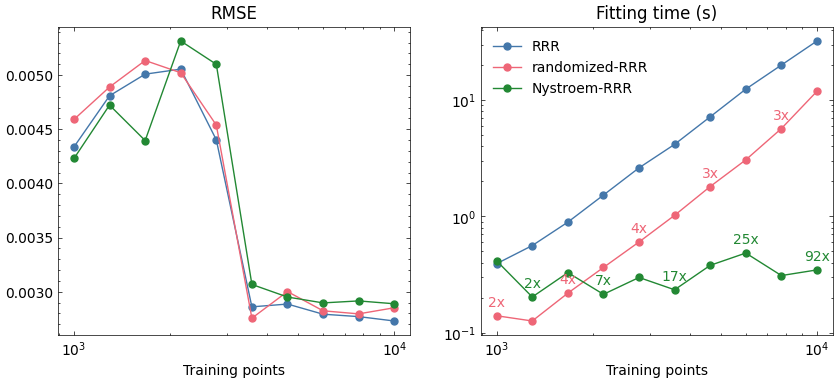

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, test_rMSE[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    if name == 'RRR':
        continue
    for i, el in enumerate(timings['RRR']/timings[name]):
        if (name == 'randomized-RRR') & (i % 2 == 0):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*1.2, str(int(el))+'x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR') & (i % 2 != 0):
            c = colors[2]
            ax.text(train_stops[i], timings[name][i]*1.2, str(int(el))+'x', fontsize=10, color = c, ha='center')

    print(f"Average fitting time speed-up for {name}: {speedup[name]}")